In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycodes import turnover_analysis as ta
from pycodes import isotopologue_correction as ic

In [2]:
df = pd.read_excel('../data/293/NAD_raw_mito_wcl_measurements.xlsx')
df

,experiment,cell type,time point (h),replicate number,NAD,NAD_N15,NAD_5C13,NAD_5C13N15,NAD_10C13,NAD_10C13N15
0,293 mito 1,293,0.0,1,4.026794e+07,0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
1,293 mito 1,293,1.9,1,4.025482e+07,0,1.130677e+06,5.738495e+06,0.000000,1.207506e+06
2,293 mito 1,293,3.6,1,3.234127e+07,0,2.504022e+06,1.233975e+07,0.000000,4.342977e+06
3,293 mito 1,293,6.9,1,1.957415e+07,0,3.641915e+06,1.643402e+07,0.000000,1.354280e+07
4,293 mito 2,293,0.0,2,4.531635e+07,0,0.000000e+00,2.234112e+03,2335.491611,1.315287e+04
...,...,...,...,...,...,...,...,...,...,...
223,ER WCL 2,erP,6.9,2,5.782833e+05,0,1.204196e+05,4.957111e+05,53848.109777,2.745474e+05
224,ER WCL 3,erP,0.0,3,8.683228e+05,0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
225,ER WCL 3,erP,1.9,3,1.353666e+06,0,4.437173e+04,2.699070e+05,0.000000,4.262276e+04
226,ER WCL 3,erP,3.6,3,1.669137e+06,0,1.411509e+05,6.919048e+05,36783.628134,2.083376e+05


In [3]:
df['time'] = df['time point (h)']
df_wcl = df[df['experiment'].str.contains('WCL')]
df_mito = df[df['experiment'].str.contains('mito')]

In [4]:
import itertools
from scipy import stats

def calculate_t_stats(dpars, n_samples, cell_column='cell_type'):
    t_stat = {}
    comb = [i for i in itertools.combinations(dpars[cell_column].unique(), 2)]
    for cell in comb:
        numerator = dpars[dpars[cell_column] == cell[0]].turnover.iloc[0] - \
            dpars[dpars[cell_column] == cell[1]].turnover.iloc[0]
        deno = dpars[dpars[cell_column] == cell[0]].turnover_error.iloc[0] / \
            (np.sqrt(n_samples)) + dpars[dpars[cell_column] ==
                                         cell[1]].turnover_error.iloc[0]/(np.sqrt(n_samples))
        t_stat['_'.join(cell)] = np.abs(numerator/deno)
    df_stat = pd.DataFrame.from_dict(t_stat, orient='index')
    df_stat = df_stat.rename(columns={0: 't-statistic'})
    df_stat['p-value'] = df_stat['t-statistic'].apply(
        lambda x: 2*(1 - stats.t.cdf(x, df=n_samples-1)))
    return df_stat

## Fitting the data to an exponential decay function

In [5]:
import new_utils, new_plots

In [6]:
ic_wcl = new_utils.get_iso_corr(df_raw=df_wcl, met='NAD', cell_column='cell type',
                       columns=['cell type', 'time', 'replicate number'],
                       transform='percent', threshold=0.0, xcol='time')

ic_mito = new_utils.get_iso_corr(df_raw=df_mito, met='NAD', cell_column='cell type',
                          columns=['cell type', 'time', 'replicate number'],
                          transform='percent', threshold=0.0, xcol='time')

In [7]:
N0_wcl = pd.read_csv('../data/nad_conc_new.csv', index_col=0)
N0_wcl = N0_wcl[N0_wcl['cell line'] == '293']

N0_mito = pd.read_csv('../data/nad_conc_mito_new.csv')
N0_mito.replace(',', '.', regex=True, inplace=True)
N0_mito = N0_mito.astype(float)

N0_emito = N0_wcl['mean'] - N0_mito.mean()

,cell_type,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error
0,293,0.277463,0.127741,0.010346,0.013977,5.426198,0.593726
1,mP,0.010325,0.192061,0.000568,0.025575,3.608986,0.480582
2,cP,0.181576,0.156460,0.007672,0.017441,4.430187,0.493843
3,pP,0.142825,0.213393,0.005384,0.018781,3.248226,0.285880
4,erP,0.191649,0.113257,0.006563,0.012229,6.120111,0.660809


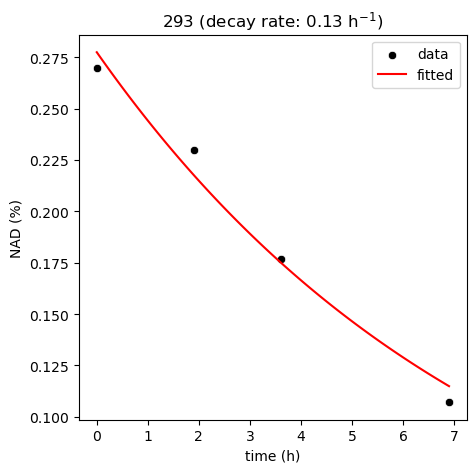

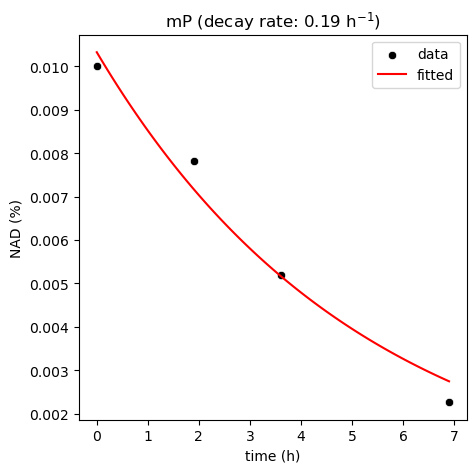

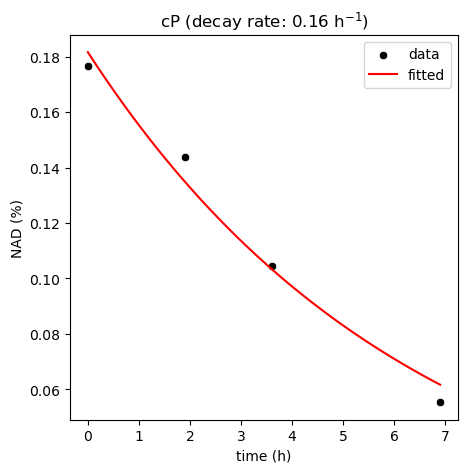

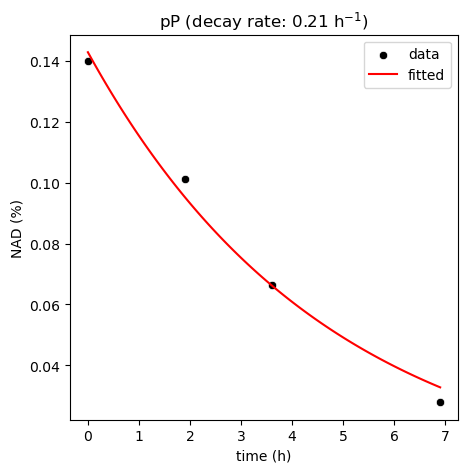

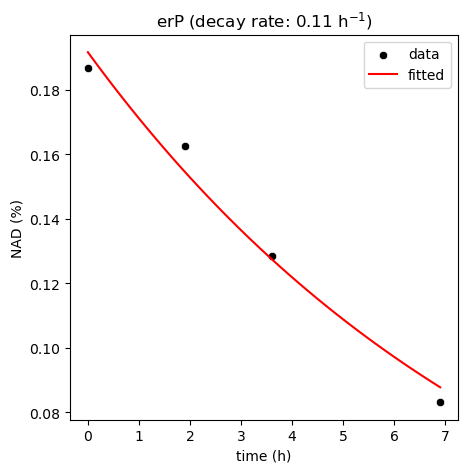

In [8]:
met = 'NAD'
cell_line = '293'
cell_column = 'cell type'
xcol = 'time'
default_path = '../results/'
folder_name = 'NAD'
show_fig = False
save_fig = False

iso_corr_percent = ic_mito.copy()
N0_mito = N0_mito.rename(columns={'wt': '293'})

ddata = []
for cell in iso_corr_percent[cell_column].unique():
    iso_corr_percent = ic_mito[ic_mito[cell_column] == cell].groupby(
        [cell_column, 'time']).mean(numeric_only=True).mul(N0_mito[cell].mean()/100.).reset_index()
    popt, std_err, hl, hle = new_utils.plot_decay(cell_line=cell_line, cell_column=cell_column, cell=cell,
                                        met=met, iso_corr_percent=iso_corr_percent, xcol=xcol,
                                        default_path=default_path, folder_name=folder_name,
                                        save_fig=save_fig, show_fig=None)
    
    ddata.append([cell,] + [i for i in popt] +
                    [i for i in std_err] + [hl, hle])
ddata = pd.DataFrame(ddata, columns=['cell_type', 'prefactor_decay', 'decay_rate',
                        'prefactor_decay_error', 'decay_rate_error', 'half_life', 'half_life_error'])
dp_mito = ddata.copy()
# dp_mito = dp_mito.reindex(index=['wt', 'mP', 'pP', 'cP', 'erP'])
dp_mito

,cell_type,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error
0,293,2.328282,0.140948,0.039297,0.006613,4.917750,0.230744
1,mP,1.652474,0.233724,0.030995,0.009977,2.965660,0.126595
2,cP,1.998626,0.177493,0.037923,0.008401,3.905203,0.184848
3,pP,1.460325,0.239706,0.017444,0.006476,2.891651,0.078120
4,erP,1.772278,0.128872,0.020520,0.004357,5.378555,0.181821


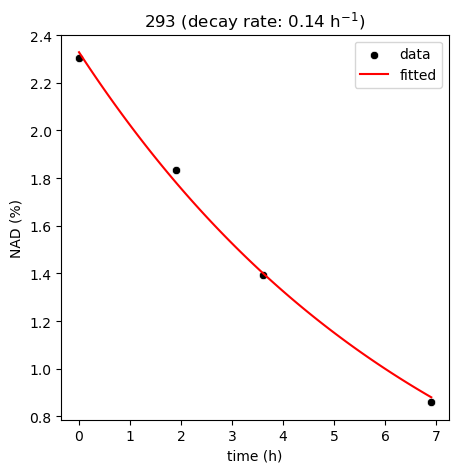

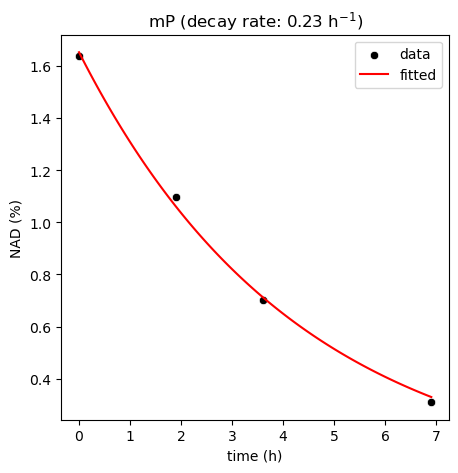

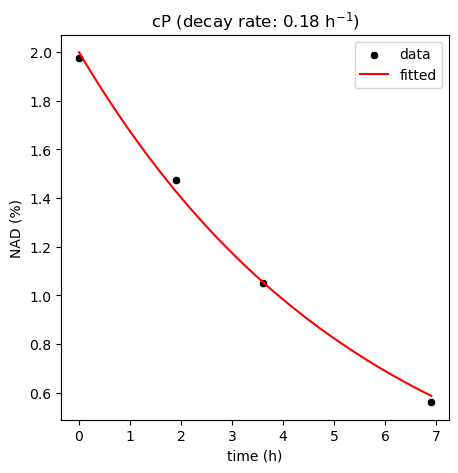

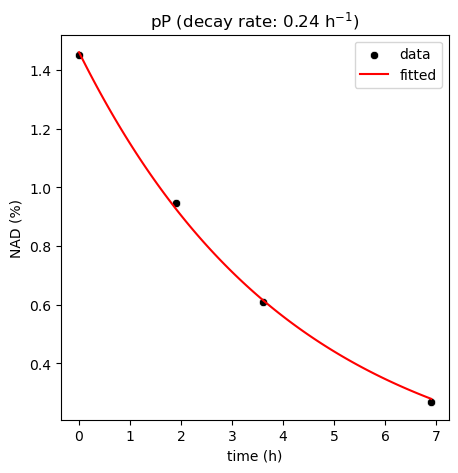

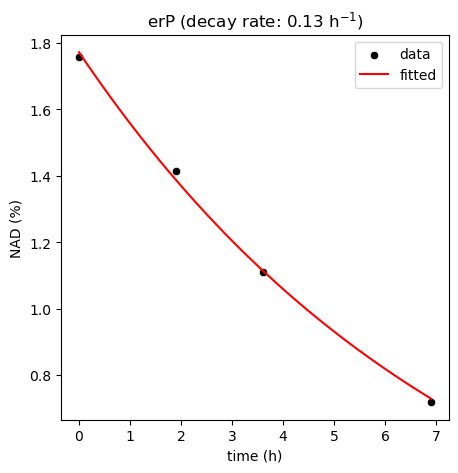

In [9]:
iso_corr_percent = ic_wcl.copy()
N0_wcl = N0_wcl.rename(index={'wt': '293'})

ddata = []
for cell in iso_corr_percent[cell_column].unique():
    iso_corr_percent = ic_wcl[ic_wcl[cell_column] == cell].groupby(
        [cell_column, 'time']).mean(numeric_only=True).mul(N0_wcl[N0_wcl.index == cell]['mean'].iloc[0]/100.).reset_index()
    popt, std_err, hl, hle = new_utils.plot_decay(cell_line=cell_line, cell_column=cell_column, cell=cell,
                                           met=met, iso_corr_percent=iso_corr_percent, xcol=xcol,
                                           default_path=default_path, folder_name=folder_name,
                                           save_fig=save_fig, show_fig=show_fig)
    ddata.append([cell,] + [i for i in popt] +
                 [i for i in std_err] + [hl, hle])
ddata = pd.DataFrame(ddata, columns=['cell_type', 'prefactor_decay', 'decay_rate',
                                     'prefactor_decay_error', 'decay_rate_error', 'half_life', 'half_life_error'])
dp_wcl = ddata.copy()
dp_wcl

In [18]:
dp_wcl

,cell_type,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error
0,293,2.328282,0.140948,0.039297,0.006613,4.917750,0.230744
1,mP,1.652474,0.233724,0.030995,0.009977,2.965660,0.126595
2,cP,1.998626,0.177493,0.037923,0.008401,3.905203,0.184848
3,pP,1.460325,0.239706,0.017444,0.006476,2.891651,0.078120
4,erP,1.772278,0.128872,0.020520,0.004357,5.378555,0.181821


In [10]:
dp_wcl.set_index('cell_type', inplace=True)
dp_wcl['poolsize'] = N0_wcl['mean']
dp_wcl['poolsize_sd'] = N0_wcl['sd']
dp_wcl['turnover'] = dp_wcl['poolsize']/2 / dp_wcl['half_life']
dp_wcl['turnover_error'] = dp_wcl['turnover'] * \
    np.sqrt((dp_wcl['poolsize_sd']/dp_wcl['poolsize'])**2 +
            (dp_wcl['half_life_error']/dp_wcl['half_life'])**2)
dp_wcl

,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
cell_type,,,,,,,,,,
293,2.328282,0.140948,0.039297,0.006613,4.917750,0.230744,2.303448,0.181999,0.234197,0.021521
mP,1.652474,0.233724,0.030995,0.009977,2.965660,0.126595,1.637505,0.192846,0.276078,0.034583
cP,1.998626,0.177493,0.037923,0.008401,3.905203,0.184848,1.976000,0.084986,0.252996,0.016180
pP,1.460325,0.239706,0.017444,0.006476,2.891651,0.078120,1.452832,0.249540,0.251211,0.043679
erP,1.772278,0.128872,0.020520,0.004357,5.378555,0.181821,1.758436,0.343391,0.163467,0.032397


<Axes: xlabel='cell_type', ylabel='turnover'>

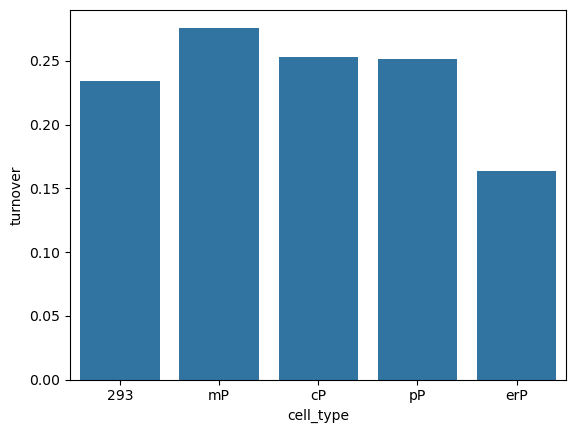

In [11]:
sns.barplot(data=dp_wcl, x=dp_wcl.index, y='turnover')
            # order=['wt', 'mP', 'pP', #'cP', 'erP'])

In [12]:
calculate_t_stats(dp_wcl.reset_index(), 6)

,t-statistic,p-value
293_mP,1.828476,0.127016
293_cP,1.221345,0.276397
293_pP,0.639201,0.550823
293_erP,3.213253,0.023643
mP_cP,1.113767,0.316035
mP_pP,0.778277,0.471611
mP_erP,4.118206,0.009190
cP_pP,0.073017,0.944623
cP_erP,4.514430,0.006315
pP_erP,2.825188,0.036883


In [13]:
dp_mito.set_index('cell_type', inplace=True)
dp_mito['poolsize'] = N0_mito.mean()
dp_mito['poolsize_sd'] = N0_mito.std()
dp_mito['turnover'] = dp_mito['poolsize']/2 / dp_mito['half_life']
dp_mito['turnover_error'] = dp_mito['turnover'] * \
    np.sqrt((dp_mito['poolsize_sd']/dp_mito['poolsize'])**2 +
            (dp_mito['half_life_error']/dp_mito['half_life'])**2)
dp_mito = dp_mito.reindex(index=['293', 'mP', 'pP', 'cP', 'erP'])
dp_mito

,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
cell_type,,,,,,,,,,
293,0.277463,0.127741,0.010346,0.013977,5.426198,0.593726,0.270000,0.043589,0.024879,0.004852
mP,0.010325,0.192061,0.000568,0.025575,3.608986,0.480582,0.010000,0.010000,0.001385,0.001398
pP,0.142825,0.213393,0.005384,0.018781,3.248226,0.285880,0.140000,0.026458,0.021550,0.004493
cP,0.181576,0.156460,0.007672,0.017441,4.430187,0.493843,0.176667,0.011547,0.019939,0.002577
erP,0.191649,0.113257,0.006563,0.012229,6.120111,0.660809,0.186667,0.047258,0.015250,0.004197


<Axes: xlabel='cell_type', ylabel='turnover'>

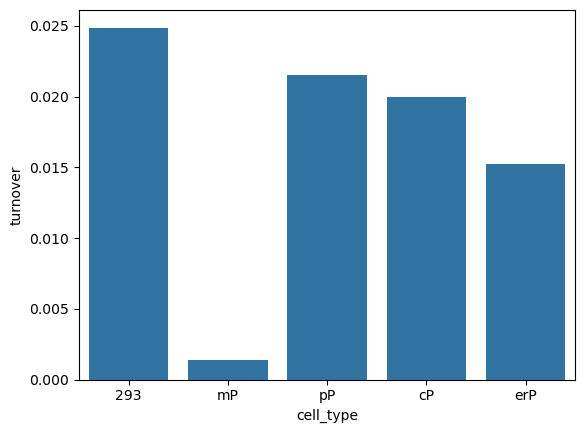

In [14]:
sns.barplot(data=dp_mito, x=dp_mito.index, y='turnover')

In [15]:
calculate_t_stats(dp_mito.reset_index(), 6)

,t-statistic,p-value
293_mP,9.207986,0.000254
293_pP,0.872635,0.422781
293_cP,1.629001,0.164242
293_erP,2.606357,0.047880
mP_pP,8.385613,0.000395
mP_cP,11.435455,0.000090
mP_erP,6.069999,0.001753
pP_cP,0.558309,0.600709
pP_erP,1.775804,0.135928
cP_erP,1.695467,0.150755


In [16]:
N0_wcl

,mean,sd,cell line
cell type,,,
293,2.303448,0.181999,293
mP,1.637505,0.192846,293
pP,1.452832,0.249540,293
cP,1.976000,0.084986,293
erP,1.758436,0.343391,293


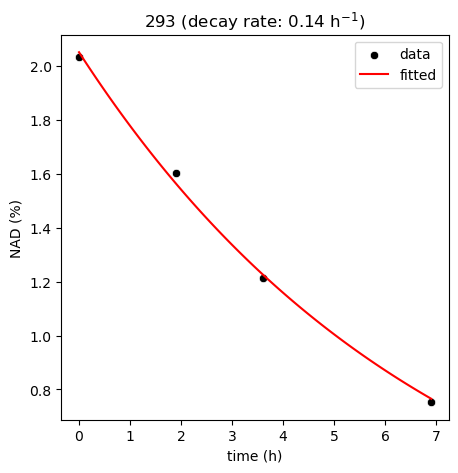

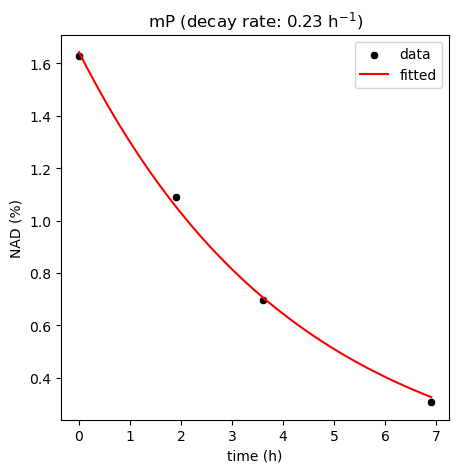

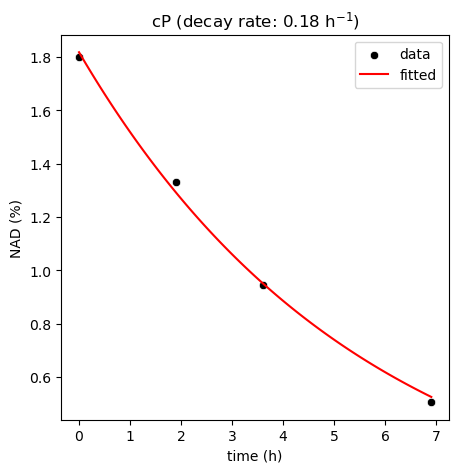

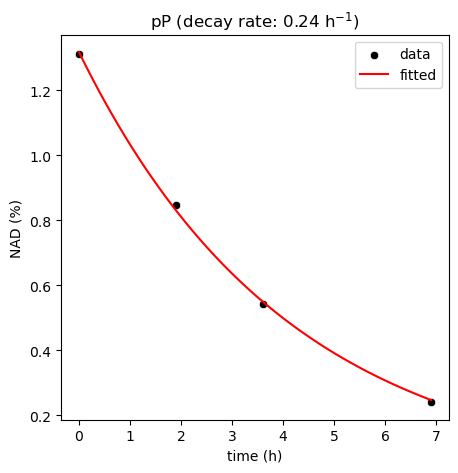

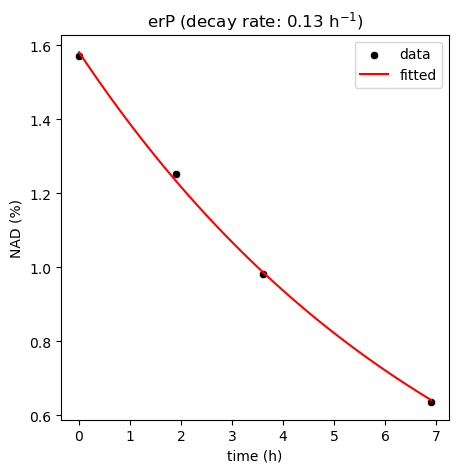

In [17]:
ddata = []
for cell in ic_wcl[cell_column].unique():
    iso_corr_wcl = ic_wcl[ic_wcl[cell_column] == cell].groupby(
        [cell_column, 'time']).mean(numeric_only=True).mul(N0_wcl[N0_wcl.index == cell]['mean'].iloc[0]/100.)
    iso_corr_mito = ic_mito[ic_mito[cell_column] == cell].groupby(
        [cell_column, 'time']).mean(numeric_only=True).mul(N0_mito[cell].mean()/100.)
    iso_corr_percent = (iso_corr_wcl - iso_corr_mito).reset_index()

    popt, std_err, hl, hle = new_utils.plot_decay(cell_line=cell_line, cell_column=cell_column, cell=cell,
                                            met=met, iso_corr_percent=iso_corr_percent, xcol=xcol,
                                            default_path=default_path, folder_name=folder_name,
                                            save_fig=save_fig, show_fig=show_fig)
    ddata.append([cell,] + [i for i in popt] +
                    [i for i in std_err] + [hl, hle])

ddata = pd.DataFrame(ddata, columns=['cell_type', 'prefactor_decay', 'decay_rate',
                                        'prefactor_decay_error', 'decay_rate_error', 'half_life', 'half_life_error'])
dp_emito = ddata.copy()
dp_emito.set_index('cell_type', inplace=True)

In [18]:
dp_emito['poolsize'] = N0_wcl['mean'] - N0_mito.mean()
dp_emito['poolsize_sd'] = dp_emito['poolsize'] * \
    np.sqrt((N0_wcl['sd']/N0_wcl['mean'])**2)
dp_emito['turnover'] = dp_emito['poolsize']/2 / dp_emito['half_life']
dp_emito['turnover_error'] = dp_emito['turnover'] * \
    np.sqrt((dp_emito['poolsize_sd']/dp_emito['poolsize'])**2 +
            (dp_emito['half_life_error']/dp_emito['half_life'])**2)
dp_emito

,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
cell_type,,,,,,,,,,
293,2.051087,0.142869,0.029677,0.005706,4.851616,0.193768,2.033448,0.160666,0.209564,0.018553
mP,1.642193,0.234030,0.030473,0.009880,2.961787,0.125038,1.627505,0.191669,0.274751,0.034373
cP,1.817350,0.179807,0.030575,0.007507,3.854951,0.160941,1.799333,0.077388,0.233380,0.013989
pP,1.317779,0.242905,0.012576,0.005226,2.853573,0.061398,1.312832,0.225493,0.230033,0.039820
erP,1.580871,0.130924,0.014375,0.003445,5.294282,0.139312,1.571769,0.306938,0.148440,0.029250


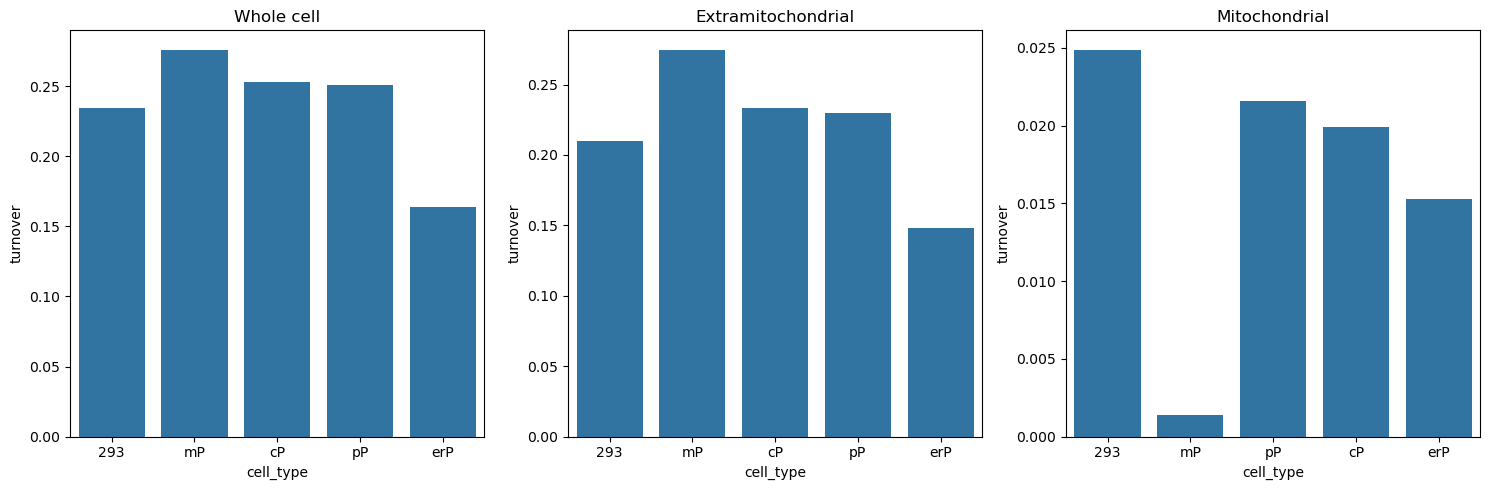

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=dp_wcl, x=dp_wcl.index, y='turnover', ax=ax[0])
sns.barplot(data=dp_emito, x=dp_emito.index, y='turnover', ax=ax[1])
sns.barplot(data=dp_mito, x=dp_mito.index, y='turnover', ax=ax[2])
ax[0].set_title('Whole cell')
ax[1].set_title('Extramitochondrial')
ax[2].set_title('Mitochondrial')
plt.tight_layout()

In [20]:
dp_wcl

,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
cell_type,,,,,,,,,,
293,2.328282,0.140948,0.039297,0.006613,4.917750,0.230744,2.303448,0.181999,0.234197,0.021521
mP,1.652474,0.233724,0.030995,0.009977,2.965660,0.126595,1.637505,0.192846,0.276078,0.034583
cP,1.998626,0.177493,0.037923,0.008401,3.905203,0.184848,1.976000,0.084986,0.252996,0.016180
pP,1.460325,0.239706,0.017444,0.006476,2.891651,0.078120,1.452832,0.249540,0.251211,0.043679
erP,1.772278,0.128872,0.020520,0.004357,5.378555,0.181821,1.758436,0.343391,0.163467,0.032397


In [21]:
dp_emito

,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
cell_type,,,,,,,,,,
293,2.051087,0.142869,0.029677,0.005706,4.851616,0.193768,2.033448,0.160666,0.209564,0.018553
mP,1.642193,0.234030,0.030473,0.009880,2.961787,0.125038,1.627505,0.191669,0.274751,0.034373
cP,1.817350,0.179807,0.030575,0.007507,3.854951,0.160941,1.799333,0.077388,0.233380,0.013989
pP,1.317779,0.242905,0.012576,0.005226,2.853573,0.061398,1.312832,0.225493,0.230033,0.039820
erP,1.580871,0.130924,0.014375,0.003445,5.294282,0.139312,1.571769,0.306938,0.148440,0.029250


In [22]:
dp_mito

,prefactor_decay,decay_rate,prefactor_decay_error,decay_rate_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
cell_type,,,,,,,,,,
293,0.277463,0.127741,0.010346,0.013977,5.426198,0.593726,0.270000,0.043589,0.024879,0.004852
mP,0.010325,0.192061,0.000568,0.025575,3.608986,0.480582,0.010000,0.010000,0.001385,0.001398
pP,0.142825,0.213393,0.005384,0.018781,3.248226,0.285880,0.140000,0.026458,0.021550,0.004493
cP,0.181576,0.156460,0.007672,0.017441,4.430187,0.493843,0.176667,0.011547,0.019939,0.002577
erP,0.191649,0.113257,0.006563,0.012229,6.120111,0.660809,0.186667,0.047258,0.015250,0.004197
